In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, Dropdown
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.stats.contingency_tables import Table2x2
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go






In [ ]:
import requests
from bs4 import BeautifulSoup


# Data scarpe of top 25 players
# URL of the page to scrape
url = 'https://bleacherreport.com/articles/10098800-ranking-the-top-25-starting-pitchers-of-2023-mlb-season'

# Send a GET request
response = requests.get(url)

# Parse the HTML content of the page with BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Based on your screenshot, it seems the player names are in 'h2' tags within specific 'div' containers
# Adjust the class names based on the exact ones that enclose the player names
player_containers = soup.find_all('div', class_='organism contentStream slide')

# Extract player names from each container
top_players = []
for container in player_containers:
    player_name = container.find('h2')
    if player_name:
        top_players.append(player_name.get_text().strip())

# Print the top 25 players
print(top_players[:25])


In [2]:
# Load data
Cole = pd.read_csv("cole_data.csv")

Ohtani = pd.read_csv("Ohtani_2018-2023.csv")
Ohtani

# Combine all data
all_data = pd.concat([Ohtani, Cole], keys=['Ohtani', 'Cole'], names=['Pitcher'])

In [3]:


Ohtani = pd.read_csv("Ohtani_2018-2023.csv")
Ohtani

# Ensure the 'game_date' column is converted to datetime
Ohtani['game_date'] = pd.to_datetime(Ohtani['game_date'])

# Create a dictionary to store DataFrames for each year
yearly_data = {}

# Loop through the years 2018 to 2023
for year in range(2018, 2024):
    # Filter the DataFrame for the current year
    mask = (Ohtani['game_date'].dt.year == year)
    yearly_data[year] = Ohtani[mask]

    # Optional: Save the DataFrame for the current year to a new CSV file
    yearly_data[year].to_csv(f"Ohtani{year}.csv", index=False)

# Access each year's data
data_2018 = yearly_data[2018]
data_2019 = yearly_data[2019]  # He didn't play this season
data_2020 = yearly_data[2020]
data_2021 = yearly_data[2021]
data_2022 = yearly_data[2022]
data_2023 = yearly_data[2023]


pitchers = {
    '2018': data_2018,
    '2020': data_2020,
    '2021': data_2021,
    '2022': data_2022,
    '2023': data_2023

}

data_2018 = pd.DataFrame(data_2018)
data_2020 = pd.DataFrame(data_2020)
data_2021 = pd.DataFrame(data_2021)
data_2022 = pd.DataFrame(data_2022)
data_2023 = pd.DataFrame(data_2023)



In [4]:
strike_descriptions = ['strike', 'swinging_strike', 'called_strike', 'swinging_strike_blocked', 'foul', 'foul_tip', 'foul_bunt']
ball_descriptions = ['ball', 'blocked_ball', 'hit_by_pitch', 'foul_bunt']
hit_into_play_descriptions = ['hit_into_play']

In [5]:
Ohtani_pitch_type_table = Ohtani['pitch_type'].value_counts().reset_index()
Ohtani_pitch_type_table.columns = ['pitch_type', 'count']

Ohtani_pitch_type_table

,pitch_type,count
0,FF,2734
1,ST,2397
2,FS,1014
3,FC,811
4,CU,428
5,SI,223
6,SL,74
7,CS,1


In [6]:
Cole_pitch_type_table = Cole['pitch_type'].value_counts().reset_index()
Cole_pitch_type_table.columns = ['pitch_type', 'count']

Cole_pitch_type_table

,pitch_type,count
0,FF,1739
1,SL,683
2,KC,396
3,CH,233
4,FC,230


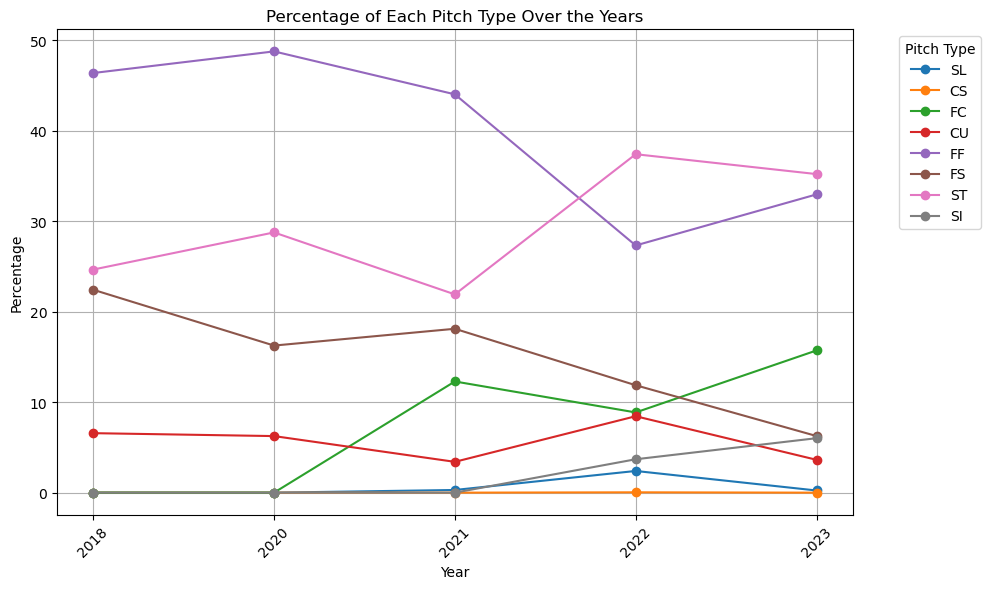

In [7]:


data_frames = {'2018': data_2018, '2020': data_2020, '2021': data_2021, '2022': data_2022, '2023': data_2023}

# Create an empty DataFrame to hold the contingency table
contingency_table = pd.DataFrame()

# Get a complete list of all pitch types across all years
all_pitch_types = set()
for df in data_frames.values():
    all_pitch_types.update(df['pitch_type'].dropna().unique())  # Drop nan values
all_pitch_types = list(all_pitch_types)

# Initialize the contingency table with zeros for all years and pitch types
years = list(data_frames.keys())
contingency_table = pd.DataFrame(0, index=years, columns=all_pitch_types)

# Process each year's data
for year, df in data_frames.items():
    pitch_counts = df['pitch_type'].value_counts()  # Get the counts of each pitch type for the current year
    for pitch_type, count in pitch_counts.items():
        contingency_table.at[year, pitch_type] = count

# Calculate percentages
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Plotting
plt.figure(figsize=(10, 6))
for pitch_type in contingency_table_percentage.columns:
    plt.plot(contingency_table_percentage.index, contingency_table_percentage[pitch_type], label=pitch_type, marker='o')

plt.title('Percentage of Each Pitch Type Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:


data_frames = {'2018': data_2018, '2020': data_2020, '2021': data_2021, '2022': data_2022, '2023': data_2023}

# Function to update the output based on the dropdown
def view_data(year):
    df = data_frames[year]
    pitch_type_counts = df['pitch_type'].value_counts().reset_index()
    pitch_type_counts.columns = ['Pitch Type', 'Count']
    # Calculate the percentage of each pitch type
    total_pitches = pitch_type_counts['Count'].sum()
    pitch_type_counts['Percentage'] = (pitch_type_counts['Count'] / total_pitches * 100).round(2).astype(str) + '%'
    return pitch_type_counts

# Create a dropdown and output widgets
dropdown = widgets.Dropdown(options=['2018', '2020', '2021', '2022', '2023'], description='Year:')
output = widgets.Output()

# Link the function to changes in the dropdown
def dropdown_eventhandler(change):
    output.clear_output()
    with output:
        display(view_data(change.new))

dropdown.observe(dropdown_eventhandler, names='value')

# Display the widgets
display(dropdown, output)



Dropdown(description='Year:', options=('2018', '2020', '2021', '2022', '2023'), value='2018')

Output()

In [76]:
#Ohtani pitch type table

# Define strike and non-strike descriptions
strike_descriptions = ['strike', 'swinging_strike', 'called_strike', 'swinging_strike_blocked', 'foul', 'foul_tip', 'foul_bunt']
non_strike_descriptions = ['ball', 'blocked_ball', 'hit_by_pitch', 'foul_bunt', 'hit_into_play']

data_frames = {'2018': data_2018, '2020': data_2020, '2021': data_2021, '2022': data_2022, '2023': data_2023}

def view_data(year):
    df = data_frames[year]
    pitch_type_counts = df['pitch_type'].value_counts().reset_index()
    pitch_type_counts.columns = ['Pitch Type', 'Count']

    # Calculate the total number of pitches
    total_pitches = pitch_type_counts['Count'].sum()

    # Calculate the percentage of each pitch type
    pitch_type_counts['Percentage'] = (pitch_type_counts['Count'] / total_pitches * 100).round(2).astype(str) + '%'

    # Calculate the strike and non-strike percentages for each pitch type
    strike_percentages = []
    non_strike_percentages = []
    for pitch_type in pitch_type_counts['Pitch Type']:
        pitch_df = df[df['pitch_type'] == pitch_type]
        strike_count = pitch_df[pitch_df['description'].isin(strike_descriptions)]['description'].count()
        non_strike_count = pitch_df[pitch_df['description'].isin(non_strike_descriptions)]['description'].count()
        total_pitch_type_count = pitch_df['description'].count()
        
        strike_percentage = (strike_count / total_pitch_type_count * 100).round(2) if total_pitch_type_count > 0 else 0
        non_strike_percentage = (non_strike_count / total_pitch_type_count * 100).round(2) if total_pitch_type_count > 0 else 0
        
        strike_percentages.append(str(strike_percentage) + '%')
        non_strike_percentages.append(str(non_strike_percentage) + '%')
    
    pitch_type_counts['Strike Percentage'] = strike_percentages
    pitch_type_counts['Non-Strike Percentage'] = non_strike_percentages

    return pitch_type_counts

# Create a dropdown and output widgets
dropdown = widgets.Dropdown(options=['2018', '2020', '2021', '2022', '2023'], description='Year:')
output = widgets.Output()

# Link the function to changes in the dropdown
def dropdown_eventhandler(change):
    output.clear_output()
    with output:
        display(view_data(change.new))

dropdown.observe(dropdown_eventhandler, names='value')

# Display the widgets
display(dropdown, output)




Dropdown(description='Year:', options=('2018', '2020', '2021', '2022', '2023'), value='2018')

Output()

In [49]:
Cole_pitch_type_table = Cole['pitch_type'].value_counts().reset_index()
Cole_pitch_type_table.columns = ['Pitch Type', 'Count']

total_pitches = Cole_pitch_type_table['Count'].sum()


Cole_pitch_type_table['Percentage'] = (Cole_pitch_type_table['Count'] / total_pitches * 100).round(2).astype(str) + '%'


strike_percentages = []
non_strike_percentages = []
for pitch_type in Cole_pitch_type_table['Pitch Type']:
    pitch_df = Cole[Cole['pitch_type'] == pitch_type]
    strike_count = pitch_df[pitch_df['description'].isin(strike_descriptions)]['description'].count()
    non_strike_count = pitch_df[pitch_df['description'].isin(non_strike_descriptions)]['description'].count()
    total_pitch_type_count = pitch_df['description'].count()

    strike_percentage = (strike_count / total_pitch_type_count * 100).round(2) if total_pitch_type_count > 0 else 0
    non_strike_percentage = (non_strike_count / total_pitch_type_count * 100).round(2) if total_pitch_type_count > 0 else 0

    strike_percentages.append(str(strike_percentage) + '%')
    non_strike_percentages.append(str(non_strike_percentage) + '%')

Cole_pitch_type_table['Strike Percentage'] = strike_percentages
Cole_pitch_type_table['Non-Strike Percentage'] = non_strike_percentages

Cole_pitch_type_table

,Pitch Type,Count,Percentage,Strike Percentage,Non-Strike Percentage
0,FF,1739,53.0%,53.77%,46.18%
1,SL,683,20.82%,44.07%,55.93%
2,KC,396,12.07%,46.72%,53.28%
3,CH,233,7.1%,36.48%,63.52%
4,FC,230,7.01%,50.87%,49.13%


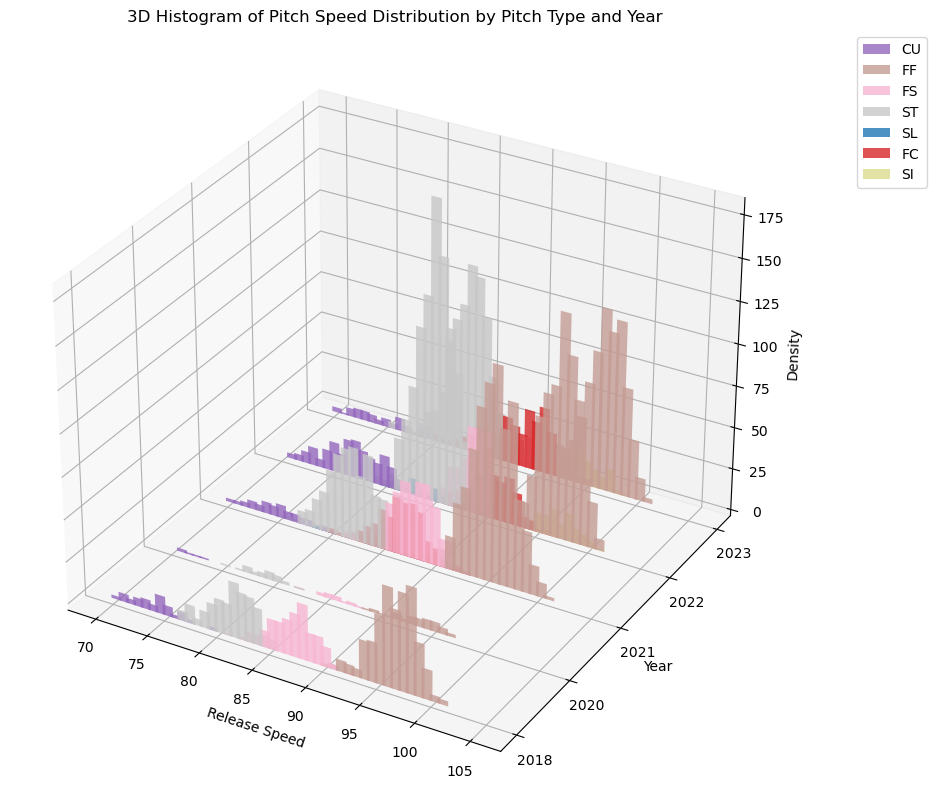

In [10]:

def plot_3d_histogram(pitchers):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    bins = np.linspace(70, 105, 50)

    all_pitch_types = set()
    for df in pitchers.values():
        all_pitch_types.update(df['pitch_type'].unique())
    all_pitch_types = list(all_pitch_types)

    # Create a color map for pitch types
    color_palette = plt.get_cmap('tab20')
    pitch_type_colors = {pt: color_palette(i / len(all_pitch_types)) for i, pt in enumerate(all_pitch_types)}

    plotted_labels = set()  # Keep track of plotted labels to avoid duplicates

    for i, (year, df) in enumerate(pitchers.items()):
        for pitch_type in all_pitch_types:
            subset = df[df['pitch_type'] == pitch_type]
            if not subset.empty:
                hist, edges = np.histogram(subset['release_speed'], bins=bins)
                centers = (edges[:-1] + edges[1:]) / 2
                if np.any(hist) and not np.isnan(hist).all():  # Only plot if histogram has non-zero values and is not all NaN
                    ax.bar(centers, hist, zs=i, zdir='y', alpha=0.8, width=1.0,
                           color=pitch_type_colors[pitch_type], label=f'{pitch_type}' if pitch_type not in plotted_labels else "")
                    plotted_labels.add(pitch_type)  # Add the pitch type to the set

    ax.set_xlabel('Release Speed')
    ax.set_ylabel('Year')
    ax.set_zlabel('Density')
    ax.set_yticks(range(len(pitchers)))
    ax.set_yticklabels(pitchers.keys())
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.title('3D Histogram of Pitch Speed Distribution by Pitch Type and Year')
    plt.show()

# Plot the 3D histogram
plot_3d_histogram(pitchers)

In [45]:
# Define colors for each year
year_colors = {
    '2018': 'blue',
    '2020': 'orange',
    '2021': 'green',
    '2022': 'red',
    '2023': 'purple'
}

# Function to create a 3D scatter plot for strikes and non-strikes for all years
def plot_3d_strike_non_strike_all_years(pitch_type, outcome):
    fig = go.Figure()

    # Process each year's data
    for year, data in data_frames.items():
        if pitch_type not in data['pitch_type'].unique():
            continue
        
        # Filter data for the selected pitch type and outcome
        filtered_data = data[(data['pitch_type'] == pitch_type) & (data['type'] == outcome)]
        
        # Add trace for the filtered data
        fig.add_trace(go.Scatter3d(
            x=filtered_data['release_pos_x'],
            y=filtered_data['release_pos_z'],
            z=filtered_data['release_speed'],
            mode='markers',
            marker=dict(
                size=5,
                color=year_colors[year],
                opacity=0.8
            ),
            name=f'{pitch_type} - {("Strike" if outcome == "S" else "Non-Strike")} - {year}'
        ))

    # Update the layout
    fig.update_layout(
        title=f'{("Strike" if outcome == "S" else "Non-Strike")} for {pitch_type} (2018-2023)',
        scene=dict(
            xaxis_title='Release Position X',
            yaxis_title='Release Position Z',
            zaxis_title='Release Speed'
        ),
        legend_title="Year"
    )
    
    fig.show()

# Create a list of unique pitch types for Ohtani
all_pitch_types = set()
for df in data_frames.values():
    all_pitch_types.update(df['pitch_type'].dropna().unique())  # Ensure NaN values are excluded
all_pitch_types = sorted(all_pitch_types)

# Create dropdown widgets for pitch types and outcomes
pitch_type_dropdown = widgets.Dropdown(
    options=all_pitch_types,
    value=all_pitch_types[0],
    description='Pitch Type:',
)

outcome_dropdown = widgets.Dropdown(
    options={'Strike': 'S', 'Non-Strike': 'B'},
    value='S',
    description='Outcome:',
)

# Use ipywidgets interact to update 3D plot based on dropdown selections
interact(plot_3d_strike_non_strike_all_years, pitch_type=pitch_type_dropdown, outcome=outcome_dropdown)

interactive(children=(Dropdown(description='Pitch Type:', options=('CS', 'CU', 'FC', 'FF', 'FS', 'SI', 'SL', '…

<function __main__.plot_3d_strike_non_strike_all_years(pitch_type, outcome)>

In [47]:


# Ensure the 'game_date' column is converted to datetime
Ohtani['game_date'] = pd.to_datetime(Ohtani['game_date'])

# Remove rows with NaN values in essential columns
Ohtani = Ohtani.dropna(subset=['pitch_type', 'release_pos_x', 'release_pos_z', 'release_speed', 'stand', 'p_throws', 'type'])

# Remove the year 2019
Ohtani = Ohtani[Ohtani['game_date'].dt.year != 2019]

# Create a dictionary to store DataFrames for each year
yearly_data = {}

# Loop through the years 2018 to 2023 (excluding 2019)
for year in range(2018, 2024):
    if year != 2019:
        # Filter the DataFrame for the current year
        mask = (Ohtani['game_date'].dt.year == year)
        yearly_data[year] = Ohtani[mask]

# Define a function to plot the heatmaps including the batter's stand
def plot_ohtani_heatmaps(pitch_type, year):
    plt.figure(figsize=(18, 12))
    
    # Get data for the specified year
    data = yearly_data.get(year, pd.DataFrame())
    
    if data.empty or pitch_type not in data['pitch_type'].unique():
        plt.title(f'No data for Ohtani - {pitch_type} - {year}')
        plt.show()
        return
    
    # Filter the data for left and right-handed pitches for Ohtani
    ohtani_left_data = data[data['p_throws'] == 'L']
    ohtani_right_data = data[data['p_throws'] == 'R']
    
    # Plot heatmap for left-handed pitches (Left-handed batter)
    if pitch_type in ohtani_left_data['pitch_type'].unique():
        left_data_left_stand = ohtani_left_data[(ohtani_left_data['pitch_type'] == pitch_type) & (ohtani_left_data['stand'] == 'L')]
        if len(left_data_left_stand) > 1:  # Check if there are enough data points
            plt.subplot(2, 2, 1)
            sns.kdeplot(x=left_data_left_stand['release_pos_x'], y=left_data_left_stand['release_pos_z'], cmap='Reds', fill=True, warn_singular=False)
            plt.title(f'Ohtani - Left Handed - {pitch_type} - Batter Left - {year}')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
        else:
            plt.subplot(2, 2, 1)
            plt.title(f'Ohtani - Left Handed - {pitch_type} - Batter Left - {year} (Not enough data)')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
    
    # Plot heatmap for left-handed pitches (Right-handed batter)
    if pitch_type in ohtani_left_data['pitch_type'].unique():
        left_data_right_stand = ohtani_left_data[(ohtani_left_data['pitch_type'] == pitch_type) & (ohtani_left_data['stand'] == 'R')]
        if len(left_data_right_stand) > 1:  # Check if there are enough data points
            plt.subplot(2, 2, 2)
            sns.kdeplot(x=left_data_right_stand['release_pos_x'], y=left_data_right_stand['release_pos_z'], cmap='Reds', fill=True, warn_singular=False)
            plt.title(f'Ohtani - Left Handed - {pitch_type} - Batter Right - {year}')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
        else:
            plt.subplot(2, 2, 2)
            plt.title(f'Ohtani - Left Handed - {pitch_type} - Batter Right - {year} (Not enough data)')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
    
    # Plot heatmap for right-handed pitches (Left-handed batter)
    if pitch_type in ohtani_right_data['pitch_type'].unique():
        right_data_left_stand = ohtani_right_data[(ohtani_right_data['pitch_type'] == pitch_type) & (ohtani_right_data['stand'] == 'L')]
        if len(right_data_left_stand) > 1:  # Check if there are enough data points
            plt.subplot(2, 2, 3)
            sns.kdeplot(x=right_data_left_stand['release_pos_x'], y=right_data_left_stand['release_pos_z'], cmap='Blues', fill=True, warn_singular=False)
            plt.title(f'Ohtani - Right Handed - {pitch_type} - Batter Left - {year}')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
        else:
            plt.subplot(2, 2, 3)
            plt.title(f'Ohtani - Right Handed - {pitch_type} - Batter Left - {year} (Not enough data)')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
    
    # Plot heatmap for right-handed pitches (Right-handed batter)
    if pitch_type in ohtani_right_data['pitch_type'].unique():
        right_data_right_stand = ohtani_right_data[(ohtani_right_data['pitch_type'] == pitch_type) & (ohtani_right_data['stand'] == 'R')]
        if len(right_data_right_stand) > 1:  # Check if there are enough data points
            plt.subplot(2, 2, 4)
            sns.kdeplot(x=right_data_right_stand['release_pos_x'], y=right_data_right_stand['release_pos_z'], cmap='Blues', fill=True, warn_singular=False)
            plt.title(f'Ohtani - Right Handed - {pitch_type} - Batter Right - {year}')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
        else:
            plt.subplot(2, 2, 4)
            plt.title(f'Ohtani - Right Handed - {pitch_type} - Batter Right - {year} (Not enough data)')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
    
    plt.tight_layout()
    plt.show()

# Create a list of unique pitch types for Ohtani
ohtani_pitch_types = Ohtani['pitch_type'].unique()

# Create a list of years from 2018 to 2023, excluding 2019
years = [2018, 2020, 2021, 2022, 2023]

# Create dropdown widgets for pitch types and years
pitch_type_dropdown = widgets.Dropdown(
    options=ohtani_pitch_types,
    value=ohtani_pitch_types[0],
    description='Pitch Type:',
)

year_dropdown = widgets.Dropdown(
    options=years,
    value=years[0],
    description='Year:',
)

# Use ipywidgets interact to update heatmaps based on dropdown selections
interact(plot_ohtani_heatmaps, pitch_type=pitch_type_dropdown, year=year_dropdown)


interactive(children=(Dropdown(description='Pitch Type:', options=('FF', 'ST', 'FS', 'SI', 'CU', 'FC', 'SL', '…

<function __main__.plot_ohtani_heatmaps(pitch_type, year)>

In [108]:

# Create a list of unique pitch types for both players
ohtani_pitch_types = Ohtani['pitch_type'].unique()
cole_pitch_types = Cole['pitch_type'].unique()
all_pitch_types = sorted(set(ohtani_pitch_types).union(cole_pitch_types))

# Define a function to create 3D scatter plots
def plot_3d_heatmaps(pitch_type):
    fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]], subplot_titles=[f'Ohtani - {pitch_type}', f'Cole - {pitch_type}'])
    
    if pitch_type in ohtani_pitch_types:
        pitch_data_ohtani = Ohtani[Ohtani['pitch_type'] == pitch_type]
        fig.add_trace(
            go.Scatter3d(
                x=pitch_data_ohtani['release_pos_x'], 
                y=pitch_data_ohtani['release_pos_z'], 
                z=pitch_data_ohtani['release_speed'], 
                mode='markers',
                marker=dict(size=4, color=pitch_data_ohtani['release_speed'], colorscale='Reds', opacity=0.8),
                name=f'Ohtani - {pitch_type}'
            ),
            row=1, col=1
        )
    
    if pitch_type in cole_pitch_types:
        pitch_data_cole = Cole[Cole['pitch_type'] == pitch_type]
        fig.add_trace(
            go.Scatter3d(
                x=pitch_data_cole['release_pos_x'], 
                y=pitch_data_cole['release_pos_z'], 
                z=pitch_data_cole['release_speed'], 
                mode='markers',
                marker=dict(size=4, color=pitch_data_cole['release_speed'], colorscale='Blues', opacity=0.8),
                name=f'Cole - {pitch_type}'
            ),
            row=1, col=2
        )
    
    fig.update_layout(
        height=600, width=1200,
        title_text=f'3D Pitch Location and Speed: {pitch_type}',
        showlegend=False
    )
    
    fig.show()

# Create a dropdown widget for pitch types
pitch_type_dropdown = Dropdown(
    options=all_pitch_types,
    value=all_pitch_types[0],
    description='Pitch Type:',
)

# Use ipywidgets interact to update 3D plots based on dropdown selection
interact(plot_3d_heatmaps, pitch_type=pitch_type_dropdown)


interactive(children=(Dropdown(description='Pitch Type:', options=('CH', 'CS', 'CU', 'FC', 'FF', 'FS', 'KC', '…

<function __main__.plot_3d_heatmaps(pitch_type)>

In [106]:



def plot_3d_strikes_comparison(Ohtani, Cole):
    # Filter for strikes in each dataset
    # Assuming 'description' column includes information on whether the pitch was a strike
    Ohtani_strikes = Ohtani[Ohtani['description'].str.contains('strike')]
    Cole_strikes = Cole[Cole['description'].str.contains('strike')]

    fig = go.Figure()

    # Add Ohtani's strikes to the plot
    fig.add_trace(go.Scatter3d(
        x=Ohtani_strikes['release_pos_x'],
        y=Ohtani_strikes['release_pos_z'],
        z=Ohtani_strikes['release_speed'],
        mode='markers',
        marker=dict(
            size=3,
            color='blue',  # Color for Ohtani
            opacity=0.6
        ),
        name='Ohtani Strikes'
    ))

    # Add Cole's strikes to the plot
    fig.add_trace(go.Scatter3d(
        x=Cole_strikes['release_pos_x'],
        y=Cole_strikes['release_pos_z'],
        z=Cole_strikes['release_speed'],
        mode='markers',
        marker=dict(
            size=3,
            color='red',  # Color for Cole
            opacity=0.6
        ),
        name='Cole Strikes'
    ))

    # Update the layout
    fig.update_layout(
        scene=dict(
            xaxis_title='Release Position X',
            yaxis_title='Release Position Z',
            zaxis_title='Release Speed',
            xaxis=dict(backgroundcolor="rgb(200, 200, 230)"),
            yaxis=dict(backgroundcolor="rgb(230, 200,230)"),
            zaxis=dict(backgroundcolor="rgb(230, 230,200)")
        ),
        title='3D Scatter Plot of Ohtani vs Cole Strikes'
    )

    fig.show()

# Example usage (replace 'Ohtani' and 'Cole' with your actual DataFrame variables)
plot_3d_strikes_comparison(Ohtani, Cole)
